In [1]:
from gates import *
from states import *
from measurements import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import cma

# Initialization

In [2]:
n_photons = 50
vacuum_state = np.zeros(n_photons)
vacuum_state[0] = 1.

# from vacuum state to displaced squeezed state
coh_dis = [0.5, 0.2, 0.3, 0.3] #squeezed r*np.exp(i*phi)  and coherent |alpha|*np.exp(i*args(alpha))
gate2 = S_gate(coh_dis[0], coh_dis[1], n_photons) 
gate3 = D_gate(coh_dis[2], coh_dis[3], n_photons)

state_ = np.einsum('jk,k->j', gate2, vacuum_state)
initial_state = np.einsum('jk,k->j', gate3, state_)

# Configurations of possible gates

In [3]:
# conf1
simple_block = {'one_param':[V_gate, R_gate, V_gate], 'two_params':[S_gate, D_gate, S_gate], 'num_params':9}

# Configurations of Hamiltonians

In [4]:
# Hamiltonians 
"""
x,p  polynoms <= 6 degree
"""
ham = np.array([[0.,0.,1.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [1.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                [0.,0.,0.,0.,0.,0.,0.],
                ])

Initial_state


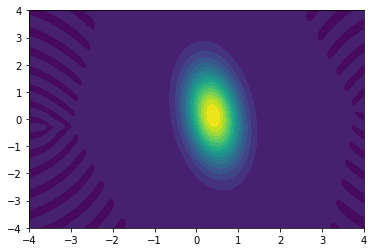

In [5]:
print("Initial_state")
init_state = initial_state.reshape(initial_state.shape[0],1)
rho = np.kron(init_state,init_state.conj().T)
xvec = np.linspace(-4,4,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [6]:
def circuit(state, params, simple_block, n_photons):
    
    number_of_single_params = len(simple_block['one_param'])
    
    for ind, gate in enumerate(simple_block['one_param']):
        state = np.einsum('jk,k->j', gate(params[ind],n_photons), state)
        
    for ind, gate in enumerate(simple_block['two_params']):
        state = np.einsum('jk,k->j', gate(params[2*ind], params[2*ind+1], n_photons), state)

    data_X = meas_X(state, n_photons)
    data_P = meas_P(state, n_photons)
    return data_X, data_P, state

def calc_loss(X, P):
    dimension = X.shape[0]
    X_sq = X**2
    P_sq = P**2
    X_cub = X**3
    P_cub = P**3
    X_quad = X**4
    P_quad = P**4
    H = np.zeros(dimension**2, dtype=np.float32)
    for i in range(dimension):
        H[i*dimension:(i+1)*dimension] = (X_sq + P_sq[i]-3/2.)**2
    return np.mean(H) + np.std(H)

In [7]:
def func_to_opt(params):
    X, P, _ = circuit(initial_state, params, simple_block, n_photons)
    return calc_loss(X, P)

In [8]:
es = cma.CMAEvolutionStrategy(6*[0.5], 0.4)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=342244, Fri Jan 17 15:28:06 2020)


In [9]:
es.optimize(func_to_opt,iterations=1000)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.059312896728516e+02 1.0e+00 3.69e-01  4e-01  4e-01 0:06.3
    2     18 5.039984130859375e+01 1.2e+00 3.97e-01  4e-01  4e-01 0:12.6
    3     27 1.462600135803223e+01 1.4e+00 4.27e-01  4e-01  5e-01 0:18.6
    4     36 8.481723785400391e+00 1.5e+00 4.26e-01  4e-01  5e-01 0:24.6
    5     45 4.738641262054443e+00 1.7e+00 4.14e-01  4e-01  4e-01 0:30.6
    6     54 8.647314071655273e+00 1.8e+00 3.89e-01  3e-01  4e-01 0:36.7
    7     63 5.966613292694092e+00 1.9e+00 3.60e-01  3e-01  4e-01 0:42.7
    9     81 7.226078033447266e+00 1.9e+00 3.09e-01  2e-01  3e-01 0:54.8
   11     99 7.636140823364258e+00 2.1e+00 2.42e-01  2e-01  2e-01 1:06.9
   13    117 4.876632213592529e+00 2.3e+00 2.06e-01  1e-01  2e-01 1:19.8
   15    135 5.898262023925781e+00 2.4e+00 1.76e-01  1e-01  2e-01 1:33.9
   17    153 3.750919103622437e+00 2.3e+00 1.49e-01  9e-02  1e-01 1:46.5
   19    171 3.765395402908325e+00 2.5e+00 1.19e-01 

KeyboardInterrupt: 

In [10]:
res = es.result_pretty().xbest

final/bestever f-value = 3.390526e+00 3.390526e+00
incumbent solution: [0.08904161174493166, 0.08473435972687438, -0.24618745073474366, 0.8372858316222493, -0.6017104284626561, 0.313182751195418]
std deviation: [0.05825500629296947, 0.06670920614332762, 0.06708403293425452, 0.07092336273394197, 0.05831883911139632, 0.08538741421995258]


In [11]:
print(*res)

0.11535697280105095 0.1323794192837964 -0.22077438640961514 0.8402940441306983 -0.6717749042636939 0.4273248453829696


H_mean + H_std = 3.619925022125244
Final_state


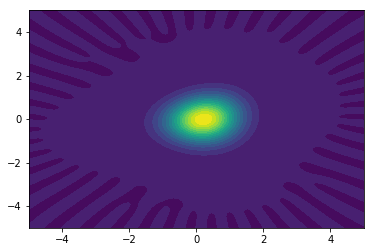

In [12]:
X, P, final_state = circuit(initial_state, res, simple_block, n_photons)
print('H_mean + H_std = {}'.format(calc_loss(X, P)))
final_state = final_state.reshape(final_state.shape[0],1)
rho_new = np.kron(final_state,final_state.conj().T)
print("Final_state")
xvec = np.linspace(-5,5,200)
W = wigner_iterative(rho_new, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [13]:
targ_state = np.zeros(n_photons)
targ_state[0] = 1.
targ_state = targ_state.reshape(targ_state.shape[0],1)
rho_targ = np.kron(targ_state, targ_state.conj().T)
fidelity(rho_new, rho_targ)

0.9753951466723374